# Heartrate Grid

notebook that creates the hr grid using heart_rate_daily.csv and dailies_summary.csv datasets

In [1]:
# imports
import pandas as pd
import datetime
import pickle

### Load Datasets

In [2]:
df_heartrate = pd.read_csv('data/heart_rate_daily.csv')
print(f'num of examples: {df_heartrate.shape[0]}\nnum of categories: {df_heartrate.shape[1]}')
df_heartrate.head()

num of examples: 55575886
num of categories: 4


,userId,dailiessummaryId,timeOffsetHeartRateSamples,pulse
0,00a7a796-c572-44d7-a950-7f6bca4a4394,x48cc04e-6313c050-15180-6,33615,83
1,00a7a796-c572-44d7-a950-7f6bca4a4394,x48cc04e-6313c050-15180-6,33630,83
2,00a7a796-c572-44d7-a950-7f6bca4a4394,x48cc04e-6313c050-15180-6,33645,83
3,00a7a796-c572-44d7-a950-7f6bca4a4394,x48cc04e-6313c050-15180-6,33660,83
4,00a7a796-c572-44d7-a950-7f6bca4a4394,x48cc04e-6313c050-15180-6,33675,83


In [3]:
df_dailies = pd.read_csv('data/dailies_summary.csv')
print(f'num of examples: {df_dailies.shape[0]}\nnum of categories: {df_dailies.shape[1]}')
df_dailies.head()

num of examples: 24815
num of categories: 34


,userId,userAccessToken,summaryId,calendarDate,activityType,activeKilocalories,bmrKilocalories,steps,distanceInMeters,durationInSeconds,...,stressDurationInSeconds,restStressDurationInSeconds,activityStressDurationInSeconds,lowStressDurationInSeconds,mediumStressDurationInSeconds,highStressDurationInSeconds,stressQualifier,floorsClimbed,consumedCalories,netKilocaloriesGoal
0,00a7a796-c572-44d7-a950-7f6bca4a4394,b3524386-eb32-4a1d-a679-1cb59eb118aa,x48cc04e-6313c050-15180-6,2022-09-04,WALKING,813,2132.0,8441,8618,86400,...,1080.0,660.0,18540.0,600.0,420.0,60.0,unknown,NaN,NaN,NaN
1,00a7a796-c572-44d7-a950-7f6bca4a4394,b3524386-eb32-4a1d-a679-1cb59eb118aa,x48cc04e-6313c050-8430-6,2022-09-04,WALKING,0,835.0,17,14,33840,...,120.0,60.0,60.0,60.0,60.0,NaN,unknown,NaN,NaN,NaN
2,00a7a796-c572-44d7-a950-7f6bca4a4394,b3524386-eb32-4a1d-a679-1cb59eb118aa,x48cc04e-631511d0-15180-6,2022-09-05,WALKING,0,2132.0,0,0,86400,...,NaN,NaN,86280.0,NaN,NaN,NaN,very_stressful_awake,NaN,NaN,NaN
3,00a7a796-c572-44d7-a950-7f6bca4a4394,b3524386-eb32-4a1d-a679-1cb59eb118aa,x48cc04e-63166350-15180-6,2022-09-06,WALKING,0,2132.0,0,0,86400,...,NaN,NaN,86400.0,NaN,NaN,NaN,very_stressful_awake,NaN,NaN,NaN
4,00a7a796-c572-44d7-a950-7f6bca4a4394,b3524386-eb32-4a1d-a679-1cb59eb118aa,x48cc04e-6317b4d0-3cf0-6,2022-09-07,WALKING,8,384.0,64,53,15600,...,300.0,NaN,14640.0,60.0,120.0,120.0,unknown,NaN,NaN,NaN


### Create heart_rate_df

Use df_dailies to add date + time and week number columns to df_heartrate.

In [4]:
def convert_unix_to_datetime(unix_timestamp):
    return datetime.datetime.fromtimestamp(unix_timestamp)

# returns the week number (1,52) of the date.
# assuming week starts on a sunday, and not a monday.
def get_week_number(date):
    adjusted_date = date - pd.Timedelta(days=(date.weekday() + 1) % 7) # date of closest, prev sunday
    return adjusted_date.isocalendar()[1]

# important note: 'calendarDate' is already the local time, so no need to use startTimeOffsetInSeconds.
def add_date_to_df(df1: pd.DataFrame, df2: pd.DataFrame) -> pd.DataFrame:
    """
    if df1 is heart_rate_daily.csv and df2 is dailies_summary.csv, then date+time column is added to df1, along with the week number
    :param df1: heart rate daily
    :param df2: daily summary
    :return: df1 with datetime and WeekNumber columns
    """
    # Create a dictionary that maps 'summaryId' to 'calendarDate' in df2
    date_dict = df2.set_index('summaryId')['calendarDate'].to_dict()

    # Add a new column 'date' to df1 by mapping 'dailiessummaryId' to 'calendarDate' using date_dict
    df1['date'] = df1['dailiessummaryId'].map(date_dict)
    df1['date'] = pd.to_datetime(df1['date'])

    # Convert 'timeOffsetHeartRateSample' from seconds to timedelta
    df1['time'] = pd.to_timedelta(df1['timeOffsetHeartRateSamples'], unit='s')

    # Add 'date' and 'timeOffsetHeartRateSample' to create a datetime representing the time of day
    df1['datetime'] = df1['date'] + df1['time']

    # about 0.01 percent of rows are NaN in 'datetime', so remove them.
    df1 = df1.dropna(subset=['datetime']).copy()

    # add week number
    df1['WeekNumber'] = df1['datetime'].apply(get_week_number)

    df1.drop(columns=['time','date','timeOffsetHeartRateSamples'], errors='ignore', inplace=True) 

    return df1


def analyze_heart_rate(df, dailies):
    return add_date_to_df(df, dailies)


In [5]:
heart_rate_df = analyze_heart_rate(df_heartrate, df_dailies)
heart_rate_df.head()

,userId,dailiessummaryId,pulse,datetime,WeekNumber
0,00a7a796-c572-44d7-a950-7f6bca4a4394,x48cc04e-6313c050-15180-6,83,2022-09-04 09:20:15,35
1,00a7a796-c572-44d7-a950-7f6bca4a4394,x48cc04e-6313c050-15180-6,83,2022-09-04 09:20:30,35
2,00a7a796-c572-44d7-a950-7f6bca4a4394,x48cc04e-6313c050-15180-6,83,2022-09-04 09:20:45,35
3,00a7a796-c572-44d7-a950-7f6bca4a4394,x48cc04e-6313c050-15180-6,83,2022-09-04 09:21:00,35
4,00a7a796-c572-44d7-a950-7f6bca4a4394,x48cc04e-6313c050-15180-6,83,2022-09-04 09:21:15,35


### Heart rate grid creation 

In [ ]:
users_weekly_hr = {}

```python
users_weekly_hr = {
    userID: {
        week_number: pd.DataFrame(userId, dailiessummaryId, pulse, datetime, WeekNumber)
    }
}

In [7]:
for user, user_df in heart_rate_df.groupby('userId'):
    weekly_user_df = {}
    for week_num, week_df in user_df.groupby('WeekNumber'):
        week_df = week_df.reset_index(drop=True) # reset index to start at 0
        weekly_user_df[week_num] = week_df
    users_weekly_hr[user] = weekly_user_df

In [8]:
pickle_file_path = 'heart_rate_grid.pkl'
with open(pickle_file_path, 'wb') as file:
    pickle.dump(users_weekly_hr, file)

## Example

This example shows the relation between heart rate (hr grid) and speed (steps grid). They match up pretty well.

In [9]:
example_user_id = 'fd949638-b68e-4e68-b660-f31133ed2a19'

In [11]:
# load the steps grid
with open('steps_grid.pkl', 'rb') as file:
    steps_data = pickle.load(file)
example_user_id in steps_data.keys()

True

In [14]:
df_subset_hr = users_weekly_hr['fd949638-b68e-4e68-b660-f31133ed2a19'][34].iloc[0:330]
df_subset_hr

,userId,dailiessummaryId,pulse,datetime,WeekNumber
0,fd949638-b68e-4e68-b660-f31133ed2a19,x48c7762-630bd750-15180-6,87,2022-08-29 02:37:15,34
1,fd949638-b68e-4e68-b660-f31133ed2a19,x48c7762-630bd750-15180-6,87,2022-08-29 02:37:30,34
2,fd949638-b68e-4e68-b660-f31133ed2a19,x48c7762-630bd750-15180-6,87,2022-08-29 02:37:45,34
3,fd949638-b68e-4e68-b660-f31133ed2a19,x48c7762-630bd750-15180-6,87,2022-08-29 02:38:00,34
4,fd949638-b68e-4e68-b660-f31133ed2a19,x48c7762-630bd750-15180-6,97,2022-08-29 02:38:15,34
...,...,...,...,...,...
325,fd949638-b68e-4e68-b660-f31133ed2a19,x48c7762-630bd750-15180-6,69,2022-08-29 03:59:30,34
326,fd949638-b68e-4e68-b660-f31133ed2a19,x48c7762-630bd750-15180-6,69,2022-08-29 03:59:45,34
327,fd949638-b68e-4e68-b660-f31133ed2a19,x48c7762-630bd750-15180-6,69,2022-08-29 04:00:00,34
328,fd949638-b68e-4e68-b660-f31133ed2a19,x48c7762-630bd750-15180-6,84,2022-08-29 04:00:15,34


In [16]:
df_subset_steps = steps_data['fd949638-b68e-4e68-b660-f31133ed2a19'][34].iloc[1:8]
df_subset_steps

,startTimeLocal,steps,userId,activeTimeInSeconds,distanceInMeters,speed,is_running
1,2022-08-29 02:30:00,246,fd949638-b68e-4e68-b660-f31133ed2a19,900,219.03,1.877400,False
2,2022-08-29 02:45:00,931,fd949638-b68e-4e68-b660-f31133ed2a19,780,914.85,4.222385,False
3,2022-08-29 03:00:00,118,fd949638-b68e-4e68-b660-f31133ed2a19,900,95.02,1.900400,False
4,2022-08-29 03:15:00,228,fd949638-b68e-4e68-b660-f31133ed2a19,900,198.51,1.985100,False
5,2022-08-29 03:30:00,79,fd949638-b68e-4e68-b660-f31133ed2a19,900,63.62,3.817200,False
6,2022-08-29 03:45:00,63,fd949638-b68e-4e68-b660-f31133ed2a19,900,50.74,1.014800,False
7,2022-08-29 04:00:00,503,fd949638-b68e-4e68-b660-f31133ed2a19,900,533.52,2.910109,False


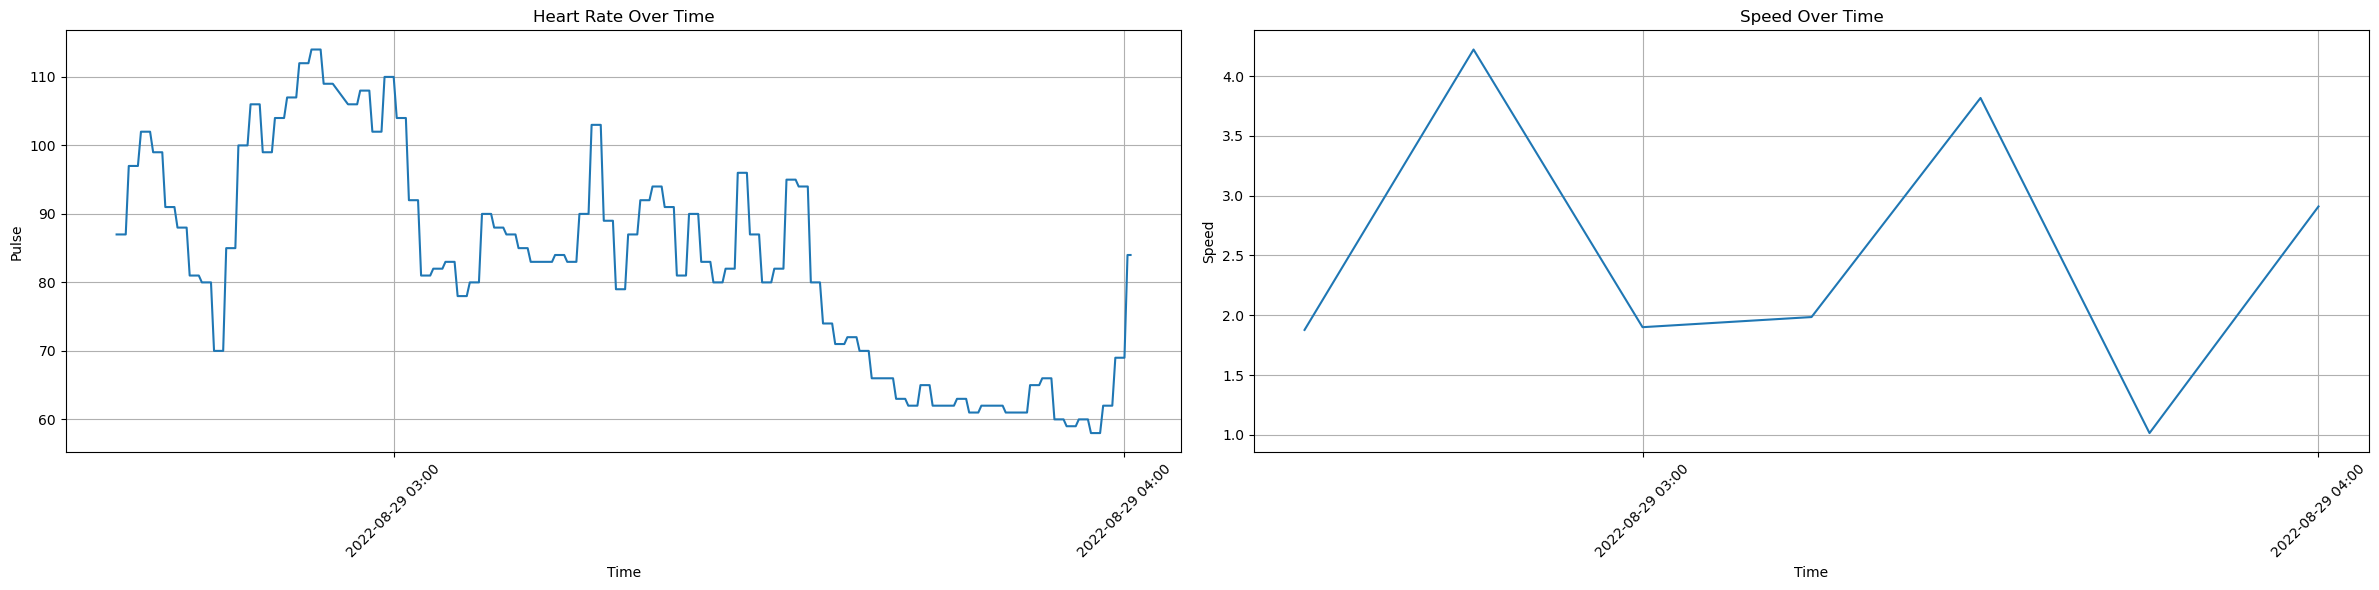

In [21]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Create a figure with two subplots side by side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(24, 6))

# Plot 1: Heart Rate Over Time
axes[0].plot(df_subset_hr['datetime'], df_subset_hr['pulse'], linestyle='-', markersize=3)
axes[0].set_title('Heart Rate Over Time')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Pulse')
axes[0].grid(True)

# Formatting the x-axis to show dates clearly
axes[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
axes[0].xaxis.set_major_locator(mdates.HourLocator(interval=1))
axes[0].tick_params(axis='x', rotation=45)

# Plot 2: Speed Over Time
axes[1].plot(df_subset_steps['startTimeLocal'], df_subset_steps['speed'], linestyle='-', markersize=3)
axes[1].set_title('Speed Over Time')
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Speed')
axes[1].grid(True)

# Formatting the x-axis to show dates clearly
axes[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
axes[1].xaxis.set_major_locator(mdates.HourLocator(interval=1))
axes[1].tick_params(axis='x', rotation=45)

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plots
plt.show()
